In [1]:
RANDOM_STATE: int = 151
SEQ_LEN: int = 8
COMPOSITIONS_PER_CLASS: int = 50
CHORDS_VOCAB_SIZE: int = 15000

In [2]:
import pandas as pd


midi_files: pd.DataFrame = pd.read_csv("./data/meta.csv")
classic_midi_files: pd.DataFrame = midi_files[midi_files["IsClassic"] == True].head(COMPOSITIONS_PER_CLASS)
not_classic_midi_files: pd.DataFrame = midi_files[midi_files["IsClassic"] == False].head(COMPOSITIONS_PER_CLASS)
midi_files = pd.concat([classic_midi_files, not_classic_midi_files])
midi_files

,Path,IsClassic
0,classic/chpn-p20.mid,True
1,classic/scn16_6.mid,True
2,classic/chpn-p12.mid,True
3,classic/bor_ps2.mid,True
4,classic/scn15_1.mid,True
...,...,...
337,anime/Mirai - Orange.mid,False
338,anime/TEMPEST.mid,False
339,anime/Heart Realize - Noragami copy.mid,False
340,anime/[dragon_ball_super_op_1]_chouzetsu_dynam...,False


In [3]:
import music21
from typing import List, Any, Tuple, Dict


class MidiSeqProcessor:
    def __init__(self, seq_len: int):
        self._seq_len: int = seq_len
    
    def get_sequences(self, score: Any) -> Tuple[List[str], List[str]]:
        """
        :param score: midi score to parse
        :return: sequences list with chords representation and duration
        """
        chords: List[str] = []
        durations: List[str] = []
        for element in score:
            if isinstance(element, music21.chord.Chord):
                chords.append("|".join([str(note) for note in element.pitches]))
                durations.append(str(element.duration.quarterLength))
            elif isinstance(element, music21.note.Note):
                chords.append(str(element.pitch))
                durations.append(str(element.duration.quarterLength))
        chord_sequences: List[str] = []
        duration_sequences: List[str] = []
        for i in range(len(chords) - self._seq_len):
            chord_sequences.append(" ".join(chords[i:i+self._seq_len]))
            duration_sequences.append(" ".join(durations[i:i+self._seq_len]))
        return chord_sequences, duration_sequences

In [4]:
import os
import logging


logging.basicConfig(level=logging.INFO)


class MusicDataFrameGenerator:
    def __init__(self, seq_len: int):
        self._seq_len: int = seq_len
        self._seq_processor: MidiSeqProcessor = MidiSeqProcessor(seq_len)

    def __call__(self, data_dir: str, midi_files: pd.DataFrame) -> pd.DataFrame:
        result: Dict[str: List] = {"ChordSeq": [], "DurationSeq": [], "IsClassic": []}
        for i, path_to_file, is_classic in zip(range(len(midi_files["Path"])), midi_files["Path"], midi_files["IsClassic"]):
            logging.info(f"Processed {i} files from {len(midi_files['Path'])}")
            path_to_file = os.path.join(data_dir, path_to_file)
            score = music21.converter.parse(path_to_file).chordify()
            for chord_seq, duration_seq in zip(*self._seq_processor.get_sequences(score)):
                result["ChordSeq"].append(chord_seq)
                result["DurationSeq"].append(duration_seq)
                result["IsClassic"].append(1 if is_classic else 0)
        return pd.DataFrame.from_dict(result)

data_frame_generator: MusicDataFrameGenerator = MusicDataFrameGenerator(SEQ_LEN)
music_data: pd.DataFrame = data_frame_generator("./data", midi_files)
music_data

INFO:root:Processed 0 files from 100
INFO:root:Processed 1 files from 100
INFO:root:Processed 2 files from 100
INFO:root:Processed 3 files from 100
INFO:root:Processed 4 files from 100
INFO:root:Processed 5 files from 100
INFO:root:Processed 6 files from 100
INFO:root:Processed 7 files from 100
INFO:root:Processed 8 files from 100
INFO:root:Processed 9 files from 100
INFO:root:Processed 10 files from 100
INFO:root:Processed 11 files from 100
INFO:root:Processed 12 files from 100
INFO:root:Processed 13 files from 100
INFO:root:Processed 14 files from 100
INFO:root:Processed 15 files from 100
INFO:root:Processed 16 files from 100
INFO:root:Processed 17 files from 100
INFO:root:Processed 18 files from 100
INFO:root:Processed 19 files from 100
INFO:root:Processed 20 files from 100
INFO:root:Processed 21 files from 100
INFO:root:Processed 22 files from 100
INFO:root:Processed 23 files from 100
INFO:root:Processed 24 files from 100
INFO:root:Processed 25 files from 100
INFO:root:Processed 26

,ChordSeq,DurationSeq,IsClassic
0,C2|C3|G3|C4|E-4|G4 F1|F2|G#3|C4|E-4|G#4 G1|G2|...,1.0 1.0 0.75 0.25 1.0 1.0 1.0 0.75,1
1,F1|F2|G#3|C4|E-4|G#4 G1|G2|G3|B3|E-4|G4 G1|G2|...,1.0 0.75 0.25 1.0 1.0 1.0 0.75 0.25,1
2,G1|G2|G3|B3|E-4|G4 G1|G2|G3|B3|D4|F4 C2|G2|C3|...,0.75 0.25 1.0 1.0 1.0 0.75 0.25 1.0,1
3,G1|G2|G3|B3|D4|F4 C2|G2|C3|E-3|G3|C4|E-4 G#1|G...,0.25 1.0 1.0 1.0 0.75 0.25 1.0 1.0,1
4,C2|G2|C3|E-3|G3|C4|E-4 G#1|G#2|E-3|G#3|C4|E-4 ...,1.0 1.0 1.0 0.75 0.25 1.0 1.0 1.0,1
...,...,...,...
93711,C#3|F3|C#4|F4|C5 C#4|F4|C5 E-2|E-3|C5 E-2|E-3|...,0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25,0
93712,C#4|F4|C5 E-2|E-3|C5 E-2|E-3|B-4 E-2|E-3|C5 E-...,0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25,0
93713,E-2|E-3|C5 E-2|E-3|B-4 E-2|E-3|C5 E-2|E-3|E-5 ...,0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25,0
93714,E-2|E-3|B-4 E-2|E-3|C5 E-2|E-3|E-5 E-2|E-3|C5 ...,0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25,0


In [5]:
classic_sample: int = len(music_data[music_data["IsClassic"] == 1])
not_classic_samples: int = len(music_data[music_data["IsClassic"] == 0])
classic_sample, not_classic_samples

(61954, 31762)

Our dataset has more classic samples, so we need to downsample it.

In [6]:
classic_music_samples: pd.DataFrame = music_data[music_data["IsClassic"] == 1].head(not_classic_samples)
not_classic_music_samples: pd.DataFrame = music_data[music_data["IsClassic"] == 0]
music_data = pd.concat([classic_music_samples, not_classic_music_samples])
music_data

,ChordSeq,DurationSeq,IsClassic
0,C2|C3|G3|C4|E-4|G4 F1|F2|G#3|C4|E-4|G#4 G1|G2|...,1.0 1.0 0.75 0.25 1.0 1.0 1.0 0.75,1
1,F1|F2|G#3|C4|E-4|G#4 G1|G2|G3|B3|E-4|G4 G1|G2|...,1.0 0.75 0.25 1.0 1.0 1.0 0.75 0.25,1
2,G1|G2|G3|B3|E-4|G4 G1|G2|G3|B3|D4|F4 C2|G2|C3|...,0.75 0.25 1.0 1.0 1.0 0.75 0.25 1.0,1
3,G1|G2|G3|B3|D4|F4 C2|G2|C3|E-3|G3|C4|E-4 G#1|G...,0.25 1.0 1.0 1.0 0.75 0.25 1.0 1.0,1
4,C2|G2|C3|E-3|G3|C4|E-4 G#1|G#2|E-3|G#3|C4|E-4 ...,1.0 1.0 1.0 0.75 0.25 1.0 1.0 1.0,1
...,...,...,...
93711,C#3|F3|C#4|F4|C5 C#4|F4|C5 E-2|E-3|C5 E-2|E-3|...,0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25,0
93712,C#4|F4|C5 E-2|E-3|C5 E-2|E-3|B-4 E-2|E-3|C5 E-...,0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25,0
93713,E-2|E-3|C5 E-2|E-3|B-4 E-2|E-3|C5 E-2|E-3|E-5 ...,0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25,0
93714,E-2|E-3|B-4 E-2|E-3|C5 E-2|E-3|E-5 E-2|E-3|C5 ...,0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25,0


In [7]:

music_data.to_csv("./data/music_samples.csv")

In [8]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


X = music_data[["ChordSeq", "DurationSeq"]]
Y = music_data["IsClassic"]
train_x, test_x, train_y, test_y = train_test_split(X, Y, shuffle=True, random_state=RANDOM_STATE)
tokenizer = Tokenizer(num_words=CHORDS_VOCAB_SIZE, filters="")
tokenizer.fit_on_texts(train_x["ChordSeq"])
train_chord_seq = tokenizer.texts_to_sequences(train_x["ChordSeq"])
test_chord_seq = tokenizer.texts_to_sequences(test_x["ChordSeq"])
train_chord_seq = pad_sequences(train_chord_seq, maxlen=SEQ_LEN)
test_chord_seq = pad_sequences(test_chord_seq, maxlen=SEQ_LEN)

In [14]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow import random
from tensorflow.keras.models import load_model
import numpy as np
import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

class DisriminatorMusicModel:
    def __init__(self, seq_len: int, chords_vocab_size: int):
        random.set_seed(RANDOM_STATE)
        i = Input(shape=seq_len)
        x = Embedding(chords_vocab_size + 1, 50)(i)
        x = LSTM(128, return_sequences=True)(x)
        x = Dropout(0.3)(x)
        x = LSTM(256, return_sequences=True)(x)
        x = GlobalMaxPooling1D()(x)
        x = Dense(1, activation="sigmoid")(x)
        self._model = Model(i, x)

    def fit(self, train_chord_seq: List[str], train_y: np.array, test_chord_seq: List[str], test_y: np.array, epochs: int):
        self._model.compile(loss="binary_crossentropy", optimizer="adam", metrics="accuracy")
        return self._model.fit(train_chord_seq, train_y, epochs=epochs, validation_data=(test_chord_seq, test_y))

    def predict(self, chords: List[str]) -> float:
        return self._model.predict(np.array([chords]))

    def serialize(self, path: str):
        self._model.save(path)

    @staticmethod
    def deserialize(path: str) -> "DisriminatorMusicModel":
        res: DisriminatorMusicModel = DisriminatorMusicModel(0, 0)
        res._model = load_model('saved_model/my_model')

In [15]:
disc_music_model: DisriminatorMusicModel = DisriminatorMusicModel(SEQ_LEN, CHORDS_VOCAB_SIZE)
history = disc_music_model.fit(train_chord_seq, train_y.to_numpy(), test_chord_seq, test_y.to_numpy(), 4)

Epoch 1/4
1489/1489 [==============================] - 12s 8ms/step - loss: 0.1258 - accuracy: 0.9445 - val_loss: 0.0413 - val_accuracy: 0.9856
Epoch 2/4
1489/1489 [==============================] - 13s 9ms/step - loss: 0.0253 - accuracy: 0.9910 - val_loss: 0.0235 - val_accuracy: 0.9916
Epoch 3/4
1489/1489 [==============================] - 13s 9ms/step - loss: 0.0155 - accuracy: 0.9945 - val_loss: 0.0215 - val_accuracy: 0.9919
Epoch 4/4
1489/1489 [==============================] - 13s 8ms/step - loss: 0.0127 - accuracy: 0.9956 - val_loss: 0.0204 - val_accuracy: 0.9929


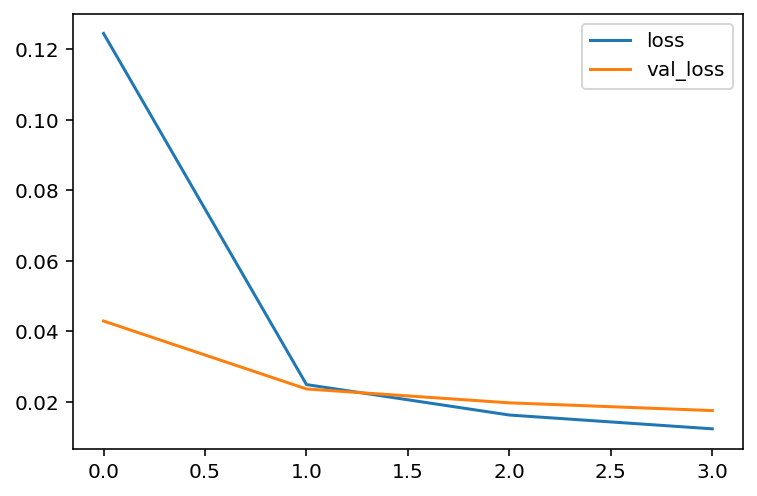

In [11]:
from matplotlib import pyplot


pyplot.plot(history.history["loss"], label="loss")
pyplot.plot(history.history["val_loss"], label="val_loss")
pyplot.legend()

In [12]:
disc_music_model.serialize("discriminator.mdl")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: discriminator.mdl/assets
